In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import os
from scipy.stats import expon
# Heston model for underlying asset prices

##implied volatility is a representation of the markets forecast of volatility
##these can be affected by outside foreces. So in this we will model that. Over time the forecast will be the longterm vol
##we model market sentiment as a random variable triggered by external forces by market event realisations
def heston_model(S0, V0, T, mu, kappa, theta, xi, rho, dt, N):
    timesteps = np.linspace(0, T, N + 1)
    S = np.zeros_like(timesteps)
    V = np.zeros_like(timesteps)
    S[0] = S0
    V[0] = V0

    for t in range(1, N + 1):
        z1 = np.random.normal()
        z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal()
        V[t] = np.abs(V[t - 1] + kappa * (theta - V[t - 1]) * dt + xi * np.sqrt(V[t - 1] * dt) * z2)
        S[t] = S[t - 1] * np.exp((mu - 0.5 * V[t]) * dt + np.sqrt(V[t] * dt) * z1)
    return S, V

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def find_iv(market_price, S, K, T, r):
    def objective(sigma): return market_price - black_scholes_call(S, K, T, r, sigma)
    try:
        return brentq(objective, 1e-6, 3.0, xtol=1e-6)
    except ValueError:
        return np.nan  # or any other default value

# Calculate log return
def calculate_log_return(S):
    return np.log(S[1:] / S[:-1])

# Adjusted calculate_skew_slope function to dynamically use TTM
def calculate_skew_slope(iv_row, ttm, moneyness_levels):
    # Select IV values for the specific TTM and moneyness levels
    atm_iv = iv_row.get((ttm, 1), 0)  # ATM IV for the specified TTM
    iv_85 = iv_row.get((ttm, 0.85), 0)  # IV for moneyness=0.85
    iv_115 = iv_row.get((ttm, 1.15), 0)  # IV for moneyness=1.15

    # Calculate skew
    skew = (iv_85 + iv_115 - 2 * atm_iv) / 2 if atm_iv else 0  # Avoid division by zero

    # Assuming slope calculation between shortest and longest TTM for simplicity
    # Adjust these values based on available TTM data in your dataset
    shortest_ttm = 1
    longest_ttm = 24
    iv_short = iv_row.get((shortest_ttm, 1), 0)  # Shortest TTM IV
    iv_long = iv_row.get((longest_ttm, 1), 0)  # Longest TTM IV

    # Calculate slope
    slope = iv_long - iv_short

    return skew, slope


# Model parameters
S0 = 100 #inital stock price
V0 = 0.04 #inital variance
T = 1 #time period
mu = 0.05 #drift of asset (long term returns)
kappa = 3.0 #rate of reversion of variance
theta = 0.04 #long term average variance
xi = 0.1 #volatility of volatility
rho = -0.7 #correlation btw stochastic process S and V
#dt = 1 / 252 #time steps
dt = 1/6000
N = int(T / dt)
r = 0.05  # Risk-free rate

# Moneyness levels and time to maturity (in years)
moneyness_levels = [0.7, 0.85, 1, 1.15, 1.3]
time_to_maturity_months = [1, 3, 6, 12, 24]

# Simulate Heston model
S, V = heston_model(S0, V0, T, mu, kappa, theta, xi, rho, dt, N)


# Calculate historical log returns
log_returns = calculate_log_return(S)

# Creating DataFrame for IV surfaces and additional features
columns = pd.MultiIndex.from_product([time_to_maturity_years, moneyness_levels], names=['TTM', 'Moneyness'])
iv_surfaces = pd.DataFrame(index=range(1, N + 1), columns=columns)
additional_features = pd.DataFrame(index=range(1, N), columns=['Log Return', 'Skew', 'Slope'])


## Adjusts IV based on moneyness: Real-world data shows that IV tends to vary with moneyness, often depicted in the "volatility smile" or "volatility skew" phenomena. IV for ATM options might be different from that of ITM or OTM options.
## Incorporates TTM effects: IV can also change with TTM, where short-term options might exhibit different IV patterns compared to long-term options.
## Reflects market conditions: Utilising θ (from the Heston model) as a baseline for market volatility, adjustments should reflect periods of high or low market volatility.
np.random.seed(42)  # For reproducibility
for i in range(1, N + 1):
    S_t = S[i]  # Current simulated asset price
    sigma_t = np.sqrt(V[i])  # Current simulated volatility
    iv_row = {}
    
    for ttm in time_to_maturity_years:
        for moneyness in moneyness_levels:
            K = S_t * moneyness
            T = ttm / 12  # Correcting TTM to years
            market_price = black_scholes_call(S_t, K, T, r, sigma_t)
            
            if moneyness == 1:  # ATM
                iv_adjustment = 0.02 + np.random.normal(0, 0.005)
            else:
                iv_adjustment = -0.01 + np.random.normal(0, 0.005)
            
            ttm_effect = 0.005 * np.log(ttm) + np.random.normal(0, 0.005)
            iv = find_iv(market_price, S_t, K, T, r) + iv_adjustment + ttm_effect
            #if np.isnan(iv):
                #continue
            iv_row[(ttm, moneyness)] = abs(iv)
    
    iv_surfaces.loc[i] = pd.Series(iv_row)
    if i > 1:  # Calculate additional features for i > 1
        skew, slope = calculate_skew_slope(iv_row, ttm, moneyness_levels)
        additional_features.at[i - 1, 'Log Return'] = log_returns[i - 2]
        additional_features.at[i - 1, 'Skew'] = skew
        additional_features.at[i - 1, 'Slope'] = slope

# Combining IV surfaces with additional features
combined_data = pd.concat([iv_surfaces.shift(-1), additional_features], axis=1).dropna()

# Save asset prices to a new file
asset_prices_data = pd.DataFrame({'Asset Price': S})
asset_prices_file_path = os.getcwd() + '/asset_prices.csv'
asset_prices_data.to_csv(asset_prices_file_path, index_label='Timestep')

print(f"Asset prices saved to: {asset_prices_file_path}")

cwd = os.getcwd()
file_path = cwd + '/combined_iv_data_bin.csv'
combined_data.to_csv(file_path)

print(f"Dataset saved to: {file_path}")

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import mibian
import random
import math

def heston_model(S0, V0, T, mu, kappa, theta, xi, rho, dt, N):
    timesteps = np.linspace(0, T, N + 1)
    S = np.zeros_like(timesteps)
    V = np.zeros_like(timesteps)
    S[0] = S0
    V[0] = V0

    for t in range(1, N + 1):
        z1 = np.random.normal()
        z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal()
        V[t] = np.abs(V[t - 1] + kappa * (theta - V[t - 1]) * dt + xi * np.sqrt(V[t - 1] * dt) * z2)
        S[t] = S[t - 1] * np.exp((mu - 0.5 * V[t]) * dt + np.sqrt(V[t] * dt) * z1)
    return S, V

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
                         
#paper shows that there is a relationship between IV and historical V to realised V
#this means that historical V and realised V is a good predictor of IV

##from paper we can have RVt = a + cIVt + e => IVt = (RVt - a) / c  + e

#the constants from the paper IVt = (RVt - 0.04)/0.7 + gaussian noise

##trend will show skew direction EMA
##ssrw will show vol in the sentiment of the ongoing direction - volatility of sentiment. This will determine the heaviness of the skew
##if the volatility is high then the current sentiment that the trend will continue will be low. - there is a great disparity between the confidence that the trend will continue 50/50 split
##if the sentiment vol is low (ssrw_abs) then the skew is strong. 

##supply and demand dynamics, market sentiment and speculation is what leads to volatiliy smiles and skew

##bs assumes that the iv is the forecast of the vol of the underlying asset so it should be the same for all options with the same maturity and underlying

##but in reality that is not the case we observe a volatility skew and smile and smirks

##these occur because of supply and demand dynamics (naturally as a result of market speculation and sentiment)

##if the market is expecting a upturn then IV will skew towards OTM call options. As the market is expecting them to become in the moeny. (price blows -> OTM call options become ITM)
##if the market is expecting a downturn then IV will skew towards OTM put options. (price falls -> OTM put options becomes ITM you will be able to sell at a profit)

##why does iv skew? because people buy up the options in the direciton of the trend upping the price. So as a result the underlying pricing model (BS) is upping the IV to account for the appreciation in price

##no skew if there is a downtrend to ITM call options cause people stand to get more rewards fromt he OTM put options

##So if there is a bullish trend skew to OTM call option
# Model parameters

S0 = 100 #inital stock price
V0 = 0.04 #inital variance
T = 1 #time period
mu = 0.05 #drift of asset (long term returns)
kappa = 3.0 #rate of reversion of variance
theta =0.04 #long term average variance
xi = 0.1 #volatility of volatility
rho = -0.7 #correlation btw stochastic process S and V
#dt = 1 / 252 #time steps
dt = 1/6000
N = int(T / dt)
r = 0.05  # Risk-free rate

S, V = heston_model(S0, V0, T, mu, kappa, theta, xi, rho, dt, N)

bid_ask_spread_bps = 5
ssrw = 0
ssrw_abs = 0


window = 25

weight = 2 / (25 + 1)

sma = S[:window].mean()
ema = [sma]

ttm_months = [1, 3, 6, 12, 24]

orderbook_ts = []
bid_ask_spread_bps = 20 #typical bidask

moneyness_elevation = 0
selected_ttms = []
for i in range(25, N):
    market_depth = random.randint(100, 150) #will determine the difference in price between the cheapest strike and most expensive strike
    S_t = S[i]
    V_t = V[i]
    ema_current = (S_t - ema[-1]) * weight + ema[-1]
    ema.append(ema_current)
    
    RVt = np.sqrt(V_t)

    IVt = (RVt - 0.04 / 0.7)
    IVt += np.random.normal(0, 0.005 * IVt) # add noise - this determines the median iv in no skew conditions
    
    ssrw = ssrw + np.random.choice([-1,1]) 
    skew_heaviness = abs(ssrw) #high number -> high confidence in trend (stronger skew), low number means low confidence in trend 

    orderbook_day_t = []
    if S_t > ema_current: ##indicates bullish trend
        ###skew to OTM call options -> more expensive strike cheapest at the top of the book - so if skew median is closer to 0
        max_iv =  np.random.uniform(0.5, 0.7) + (skew_heaviness / 10) + IVt #normal smile and skew heaviness incoroporated
        median = abs(math.floor(market_depth / 2) - skew_heaviness) #unlikely but skew heaviness could be bigger than market depth here so j in case we take the abs (should be close to 0 anyway if we overshoot) 

        if median < 3:
            median = 4 #avoid division by 0 and no itm options traded
        step_to_max_iv = max_iv / (market_depth - median)
        
        max_itm_iv = np.random.uniform(0.1, 0.5*max_iv)
        step_from_max_itm_iv = max_itm_iv / median
        
        min_strike = 0.5 * S_t
        max_strike = 1.5 * S_t

        strike_step = (max_strike - min_strike) / market_depth
        strike = min_strike #cheapest at top of the book

        moneyness_step = strike_step / S_t
        for i in range(0,market_depth):
            moneyness_elevation += moneyness_step
            if moneyness_elevation > 0.15:
                moneyness_elevation = 0
                selected_ttms = []
            elif len(selected_ttms) == 5:
                selected_ttms = []
            ttms_left = np.setdiff1d(ttm_months, selected_ttms)
            ttm = np.random.choice(ttms_left)
            selected_ttms.append(ttm)
            
            strike = strike + strike_step
            if i > median:
                iv = IVt + (i - median)*step_to_max_iv + 0.005 * np.log(ttm / 12)
                iv += np.random.normal(0, 0.005*abs(iv)) #add some noise
            else:
                iv = (max_itm_iv - step_from_max_itm_iv * i)  +  0.005 * np.log(ttm / 12)
                iv += np.random.normal(0, 0.005*abs(iv)) #add some noise

            market_price_call = black_scholes_call(S_t, strike, ttm / 12, r, abs(iv))
            bid = market_price_call * (1 - (bid_ask_spread_bps / (2 * 10000)))#keep at 5bp for now
            ask = market_price_call * (1 + (bid_ask_spread_bps / (2 * 10000)))
            orderbook_day_t.append([strike, ttm, bid, ask, abs(iv)])
            #print(f"strike price: {strike} || bid: {bid} || ask: {ask} || iv: {abs(iv)}")
    else:
        ###spread evenly for median iv calculated ATM option at the middle. With a volatility smile
        smile = np.random.uniform(0.3, 0.5)
        median = math.floor(market_depth / 2)
        smile_step = smile / median #smile decrease from the most ITM option to ATM and increase from ATM to OTM
        
        ##here ATM is in the middle, 50% increase in strike to one side, 50% to another sie
        min_strike = 0.5 * S_t
        max_strike = 1.5 * S_t

        strike_step = (max_strike - min_strike) / market_depth
        strike = min_strike #cheapest at top of the book

        moneyness_step = strike_step / S_t
        for i in range(0,market_depth):
            moneyness_elevation += moneyness_step
            if moneyness_elevation > 0.15:
                moneyness_elevation = 0
                selected_ttms = []
            elif len(selected_ttms) == 5:
                selected_ttms = []
            ttms_left = np.setdiff1d(ttm_months, selected_ttms)
            ttm = np.random.choice(ttms_left)
            selected_ttms.append(ttm)
            
            strike = strike + strike_step
            if i > median:
                iv = IVt + (i - median) * smile_step +  0.005 * np.log(ttm / 12)
                iv += np.random.normal(0, 0.005*abs(iv)) #add some noise
            else:
                iv = (smile - smile_step * i) + IVt +  0.005 * np.log(ttm / 12)
                iv += np.random.normal(0, 0.005*abs(iv)) #add some noise

            market_price_call = black_scholes_call(S_t, strike, ttm / 12, r, abs(iv))
            bid = market_price_call * (1 - (bid_ask_spread_bps / (2 * 10000)))#keep at 5bp for now
            ask = market_price_call * (1 + (bid_ask_spread_bps / (2 * 10000)))
            orderbook_day_t.append([strike, ttm, bid, ask, abs(iv)])
            #print(f"strike price: {strike} || bid: {bid} || ask: {ask} || iv: {abs(iv)}")
            
    orderbook_ts.append({
        'underlying_price': S_t,
        'options_data': orderbook_day_t
    })

df_orderbook = pd.DataFrame(orderbook_ts)
df_orderbook.head()

df_orderbook.to_csv("orderbook_ts.csv")

/var/folders/sl/_44jn7jx03b17y35qvlp17sr0000gn/T/ipykernel_98806/2288814024.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [2]:
moneyness_levels = [0.7, 0.85, 1, 1.15, 1.3]

def moneyness_and_ttm_parser(underlying_price, strike_price, T):
    moneyness = underlying_price / strike_price
    min_diff = float('inf')
    moneyness_index =  -1
    ttm_index = -1
    
    counter = 0
    for level in moneyness_levels:
        diff = abs(moneyness - level)
        #print(diff)
        if diff < min_diff:
            min_diff = diff
            moneyness_index = counter
        counter = counter + 1

    counter=0
    for ttm in ttm_months:
        if T == ttm:
            ttm_index = counter
        counter = counter + 1

    return min_diff, moneyness_index, ttm_index
    
def calculate_log_returns(S):
    return np.log(S[1:] / S[:-1])

In [ ]:
orderbook_ts = pd.read_csv('orderbook_ts.csv')

##now i need iv data with extra features in a timeseries

iv_surfaces_and_extra_features = []
extra_features = []

S = orderbook_ts['underlying_price'].values
log_returns = calculate_log_returns(S)

time_step = 0

ttm_counter = [0,0,0,0,0]
moneyness_counter = [0,0,0,0,0]
for index, row in df_orderbook.iterrows():
    S = row['underlying_price']
    options_data = row['options_data']

    iv_data = np.zeros((5,5))
    iv_counter = np.zeros((5,5))
    
    #print("Options Data:")
    for option in options_data:
        strike, ttm, bid, ask, iv = option
        distance_to_moneyness_level, moneyness_index, ttm_index = moneyness_and_ttm_parser(S, strike, ttm)
        if distance_to_moneyness_level <= 0.15 and moneyness_index != -1 and ttm_index != -1:
            iv_data[ttm_index][moneyness_index] += iv
            iv_counter[ttm_index][moneyness_index] += 1

    print(f"iv_counter: {iv_counter}")
    iv_data = iv_data / iv_counter

    print(f"iv_data: {iv_data}")
    skew = ((iv_data[3][1] - iv_data[3][3]) / 2) - iv_data[3][2]
    slope = iv_data[4][2] - iv_data[1][2]
    log_return_t = 0
    
    if time_step > 0: #index 0 represents ln(S[1] / S[0]) so log returns at t=1
        log_return_t = log_returns[time_step - 1]

    iv_surfaces_and_extra_features.append({
        'iv_surface_flattened': iv_data.flatten(),
        'skew': skew,
        'slope': slope,
        'log_returns': log_return_t
    })
    time_step += 1

cvae_training_data = pd.DataFrame(iv_surfaces_and_extra_features)

cvae_training_data.head()
cvae_training_data.to_csv('cvae_training_data.csv')

(5975, 5, 5)


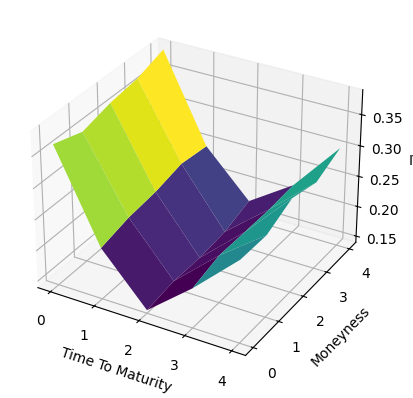

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


df = pd.read_csv('cvae_training_data.csv')
X = np.array([np.fromstring(iv_surface[1:-1], sep=' ').reshape(5, 5) for iv_surface in df['iv_surface_flattened']])

print(X.shape)
matrix = X[453]

# Generating grid
x = np.arange(5)
y = np.arange(5)
x, y = np.meshgrid(x, y)
z = matrix

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('Time To Maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('IV')
plt.show()